In [4]:
import numpy as np
import skbeam.core.utils as utils
import skbeam.core.roi as roi
import itertools

In [5]:
def _validate_and_transform_inputs1(num_bufs, num_levels, labels):
    """
    This is a helper function to validate inputs and create initial state
    inputs for both one time and two time correlation

    Parameters
    ----------
    num_bufs : int
    num_levels : int
    labels : array
        labeled array of the same shape as the image stack;
        each ROI is represented by a distinct label (i.e., integer)

    Returns
    -------
    label_array : array
        labels of the required region of interests(ROI's)
    pixel_list : array
        1D array of indices into the raveled image for all
        foreground pixels (labeled nonzero)
        e.g., [5, 6, 7, 8, 14, 15, 21, 22]
    num_rois : int
        number of region of interests (ROI)
    num_pixels : array
        number of pixels in each ROI
    lag_steps : array
        the times at which the correlation was computed
    buf : array
        image data for correlation
    img_per_level : array
        to track how many images processed in each level
    track_level : array
        to track processing each level
    cur : array
        to increment the buffer
    norm : dict
        to track bad images
    lev_len : array
        length of each levels
    """
    if num_bufs % 2 != 0:
        raise ValueError("There must be an even number of `num_bufs`. You "
                         "provided %s" % num_bufs)
    label_array = []
    pixel_list = []

    label_array, pixel_list = roi.extract_label_indices(labels)
    # map the indices onto a sequential list of integers starting at 1
    label_mapping = {label: n+1
                     for n, label in enumerate(np.unique(label_array))}
    # remap the label array to go from 1 -> max(_labels)
    for label, n in label_mapping.items():
        label_array[label_array == label] = n

    # number of ROI's
    num_rois = len(label_mapping)

    # stash the number of pixels in the mask
    num_pixels = np.bincount(label_array)[1:]

    # Convert from num_levels, num_bufs to lag frames.
    tot_channels, lag_steps, dict_lag = utils.multi_tau_lags(num_levels, num_bufs)

    # these norm and lev_len will help to find the one time correlation
    # normalization norm will updated when there is a bad image
    norm = {key: [0] * len(dict_lag[key]) for key in (dict_lag.keys())}
    lev_len = np.array([len(dict_lag[i]) for i in (dict_lag.keys())])

    # Ring buffer, a buffer with periodic boundary conditions.
    # Images must be keep for up to maximum delay in buf.
    # separate buffer for each ROI
    buf = {}
    for i in range(num_rois):
        buf[i] = np.zeros((num_levels, num_bufs,
                           len(pixel_list[label_array == i+1])),
                          dtype=np.float64)
    # to track how many images processed in each level
    img_per_level = np.zeros(num_levels, dtype=np.int64)
    # to track which levels have already been processed
    track_level = np.zeros(num_levels, dtype=bool)
    # to increment buffer
    cur = np.ones(num_levels, dtype=np.int64)

    return (label_array, pixel_list, num_rois, num_pixels,
            lag_steps, buf, img_per_level, track_level, cur,
            norm, lev_len)


In [186]:
num_levels = 4
num_bufs = 4  # must be even
xdim = 20
ydim = 20
stack_size = 20
synthetic_data = np.random.randint(1, 100, (stack_size, xdim, ydim))

rois = np.zeros_like(synthetic_data[0])
# make sure that the ROIs can be any integers greater than 1. They do not
# have to start at 1 and be continuous
rois[0:xdim//10, 0:ydim//10] = 5
rois[xdim//10:xdim//5, ydim//10:ydim//5] = 3

In [187]:
label_array, pixel_list = roi.extract_label_indices(rois)

# map the indices onto a sequential list of integers starting at 1
label_mapping = {label: n+1
                     for n, label in enumerate(np.unique(label_array))}
# remap the label array to go from 1 -> max(_labels)
for label, n in label_mapping.items():
        label_array[label_array == label] = n

# number of ROI's
num_rois = len(label_mapping)
num_rois

2

In [188]:
import skbeam.core.correlation as corr
#(num_levels, num_bufs, labels, images)
corr_gen = corr.multi_tau_auto_corr(num_levels, num_bufs, rois, synthetic_data)

In [189]:
corr_gen

(array([[ 1.30537063,  1.38085711],
        [ 1.01618128,  0.9234578 ],
        [ 1.01762573,  0.94670384],
        [ 0.97184917,  1.0480799 ],
        [ 0.98837641,  1.02632055],
        [ 1.00757177,  1.00665165],
        [ 0.9846609 ,  0.99407539],
        [ 1.07841208,  1.00293637]]), array([ 0,  1,  2,  3,  4,  6,  8, 12]))

In [190]:
time = [10, 15, 20, 23, 25, 26, 27, 34, 30]

In [191]:
time[::-1]

[30, 34, 27, 26, 25, 23, 20, 15, 10]

In [192]:
time

[10, 15, 20, 23, 25, 26, 27, 34, 30]

In [193]:
for c, t in enumerate(time):
    #print (t)
    #print (time[:c][::-1])
    time_stamp = [0]
    stamp = 0
    for item in (time[:c][::-1]):
        stamp += item
        time_stamp.append(stamp)
    print ("time_stamp",time_stamp)

time_stamp [0]
time_stamp [0, 10]
time_stamp [0, 15, 25]
time_stamp [0, 20, 35, 45]
time_stamp [0, 23, 43, 58, 68]
time_stamp [0, 25, 48, 68, 83, 93]
time_stamp [0, 26, 51, 74, 94, 109, 119]
time_stamp [0, 27, 53, 78, 101, 121, 136, 146]
time_stamp [0, 34, 61, 87, 112, 135, 155, 170, 180]


In [194]:
def time_binning(time_stamps):
    time_bin = []
    all_time = [0]
    for c, t in enumerate(time_stamps):
        time = [0]
        stamp = 0
        for item in (time_stamps[:c][::-1]):
            stamp += item
            time.append(stamp)
            all_time.append(stamp)
        time_bin.append(time)
    return time_bin, np.unique(np.sort(all_time))

In [195]:
t, all_time = time_binning([2, 3, 4])

In [196]:
time = [10, 15, 20, 23, 25, 26, 27, 34, 30]
t,all_time = time_binning(time)

In [197]:
all_time

array([  0,  10,  15,  20,  23,  25,  26,  27,  34,  35,  43,  45,  48,
        51,  53,  58,  61,  68,  74,  78,  83,  87,  93,  94, 101, 109,
       112, 119, 121, 135, 136, 146, 155, 170, 180])

In [198]:
np.unique(all_time)

array([  0,  10,  15,  20,  23,  25,  26,  27,  34,  35,  43,  45,  48,
        51,  53,  58,  61,  68,  74,  78,  83,  87,  93,  94, 101, 109,
       112, 119, 121, 135, 136, 146, 155, 170, 180])

In [199]:
np.where(all_time==27)[0]

array([7])

In [200]:
all_time[all_time==10]

array([10])

In [201]:
time_track = np.zeros_like(all_time, dtype=np.int64)
time_track

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [202]:
def lazy_one_time_using_time_stamps(image_iterable, time_stamps,
                                    labels, num_bufs, num_levels=1):
    if num_bufs % 2 != 0:
        raise ValueError("There must be an even number of `num_bufs`. You "
                         "provided %s" % num_bufs)
    label_array = []
    pixel_list = []

    label_array, pixel_list = roi.extract_label_indices(labels)
    # map the indices onto a sequential list of integers starting at 1
    label_mapping = {label: n+1
                     for n, label in enumerate(np.unique(label_array))}
    # remap the label array to go from 1 -> max(_labels)
    for label, n in label_mapping.items():
        label_array[label_array == label] = n

    # number of ROI's
    num_rois = len(label_mapping)

    # stash the number of pixels in the mask
    num_pixels = np.bincount(label_array)[1:]
    
    # to increment buffer
    cur = np.ones(num_levels, dtype=np.int64)

    time_bin, all_times = time_binning(time_stamps)

    # G holds the un normalized auto- correlation result. We
    # accumulate computations into G as the algorithm proceeds.
    G = np.zeros((len(all_times), num_rois), dtype=np.float64)
    # matrix for normalizing G into g2
    
    past_intensity = np.zeros_like(G)
    # matrix for normalizing G into g2
    future_intensity = np.zeros_like(G)
    
    buf = np.zeros((num_levels, num_bufs, len(pixel_list)),
                   dtype=np.float64)

    time_track = np.zeros_like(all_time, dtype=np.int64)

    #if internal_state is None:
    #    internal_state = _init_state_one_time(num_levels, num_bufs, labels)
    # create a shorthand reference to the results and state named tuple
    #s = internal_state

    for image, timing in zip(image_iterable, time_bin):
        # Compute the correlations for all higher levels.
        level = 0

        # increment buffer
        cur[0] = (1 + cur[0]) % num_bufs
        print (timing)

        # Put the ROI pixels into the ring buffer.
        buf[0, cur[0] - 1] = np.ravel(image)[pixel_list]
        buf_no = cur[0] - 1
        
        print("timing",timing)

        # Compute the correlations between the first level
        # (undownsampled) frames. This modifies G,
        # past_intensity, future_intensity,
        # and img_per_level in place!
        _one_time_process_time_stamps(buf, G, past_intensity,
                                      future_intensity,label_array,
                                      num_bufs, num_pixels,time_track,
                                      level, buf_no, timing, all_time)

        #TODO higher levels for multi tau
        """# check whether the number of levels is one, otherwise
        # continue processing the next level
        processing = num_levels > 1

        level = 1
        while processing:
            if not s.track_level[level]:
                s.track_level[level] = True
                processing = False
            else:
                prev = (1 + (s.cur[level - 1] - 2) % num_bufs)
                s.cur[level] = (
                    1 + s.cur[level] % num_bufs)

                s.buf[level, s.cur[level] - 1] = ((
                        s.buf[level - 1, prev - 1] +
                        s.buf[level - 1, s.cur[level - 1] - 1]) / 2)

                # make the track_level zero once that level is processed
                s.track_level[level] = False

                # call processing_func for each multi-tau level greater
                # than one. This is modifying things in place. See comment
                # on previous call above.
                buf_no = s.cur[level] - 1
                _one_time_process(s.buf, s.G, s.past_intensity,
                                  s.future_intensity, s.label_array, num_bufs,
                                  s.num_pixels, s.img_per_level, level, buf_no,
                                  s.norm, s.lev_len)
                level += 1

                # Checking whether there is next level for processing
                processing = level < num_levels"""

    print ("G", G)   
    print ("past_intensity", past_intensity)
    print ("future_intensity", future_intensity)
    
    # If any past intensities are zero, then g2 cannot be normalized at
    # those levels. This if/else code block is basically preventing
    # divide-by-zero errors.
    if len(np.where(past_intensity == 0)[0]) != 0:
        g_max = np.where(past_intensity == 0)[0][0]
    else:
        g_max = past_intensity.shape[0]

    g2 = (G[:g_max]/ (past_intensity[:g_max] *
                             future_intensity[:g_max]))
    return g2, all_time
        
        
def _validate_and_transform_inputs(num_bufs, num_levels, labels):
    """
    This is a helper function to validate inputs and create initial state
    inputs for both one time and two time correlation

    Parameters
    ----------
    num_bufs : int
    num_levels : int
    labels : array
        labeled array of the same shape as the image stack;
        each ROI is represented by a distinct label (i.e., integer)

    Returns
    -------
    label_array : array
        labels of the required region of interests(ROI's)
    pixel_list : array
        1D array of indices into the raveled image for all
        foreground pixels (labeled nonzero)
        e.g., [5, 6, 7, 8, 14, 15, 21, 22]
    num_rois : int
        number of region of interests (ROI)
    num_pixels : array
        number of pixels in each ROI
    lag_steps : array
        the times at which the correlation was computed
    buf : array
        image data for correlation
    img_per_level : array
        to track how many images processed in each level
    track_level : array
        to track processing each level
    cur : array
        to increment the buffer
    norm : dict
        to track bad images
    lev_len : array
        length of each levels
    """
    if num_bufs % 2 != 0:
        raise ValueError("There must be an even number of `num_bufs`. You "
                         "provided %s" % num_bufs)
    label_array, pixel_list = roi.extract_label_indices(labels)

    # map the indices onto a sequential list of integers starting at 1
    label_mapping = {label: n+1
                     for n, label in enumerate(np.unique(label_array))}
    # remap the label array to go from 1 -> max(_labels)
    for label, n in label_mapping.items():
        label_array[label_array == label] = n

    # number of ROI's
    num_rois = len(label_mapping)

    # stash the number of pixels in the mask
    num_pixels = np.bincount(label_array)[1:]

    # Convert from num_levels, num_bufs to lag frames.
    tot_channels, lag_steps, dict_lag = utils.multi_tau_lags(num_levels, num_bufs)

    # these norm and lev_len will help to find the one time correlation
    # normalization norm will updated when there is a bad image
    norm = {key: [0] * len(dict_lag[key]) for key in (dict_lag.keys())}
    lev_len = np.array([len(dict_lag[i]) for i in (dict_lag.keys())])

    # Ring buffer, a buffer with periodic boundary conditions.
    # Images must be keep for up to maximum delay in buf.
    buf = np.zeros((num_levels, num_bufs, len(pixel_list)),
                   dtype=np.float64)
    # to track how many images processed in each level
    img_per_level = np.zeros(num_levels, dtype=np.int64)
    # to track which levels have already been processed
    track_level = np.zeros(num_levels, dtype=bool)
    # to increment buffer
    cur = np.ones(num_levels, dtype=np.int64)

    return (label_array, pixel_list, num_rois, num_pixels,
            lag_steps, buf, img_per_level, track_level, cur,
            norm, lev_len)


In [203]:
def _one_time_process_time_stamps(buf, G, past_intensity_norm,
                                  future_intensity_norm, label_array,
                                  num_bufs, num_pixels, time_track, level,
                                  buf_no, time_bin, all_time):
    """Reference implementation of the inner loop
     of lazy_one_time_using_time_stamps

    This helper function calculates G, past_intensity_norm and
    future_intensity_norm at each level, symmetric normalization is used.

    .. warning :: This modifies inputs in place.

    Parameters
    ----------
    buf : array
        image data array to use for correlation
    G : array
        matrix of auto-correlation function without normalizations
    past_intensity_norm : array
        matrix of past intensity normalizations
    future_intensity_norm : array
        matrix of future intensity normalizations
    label_array : array
        labeled array where all nonzero values are ROIs
    num_bufs : int, even
        number of buffers(channels)
    num_pixels : array
        number of pixels in certain ROI's
        ROI's, dimensions are : [number of ROI's]X1
    img_per_level : array
        to track how many images processed in each level
    level : int
        the current multi-tau level
    buf_no : int
        the current buffer number
    time_bin : list
        list of time binning

    Notes
    -----
    .. math::
        G = <I(\tau)I(\tau + delay)>
    .. math::
        past_intensity_norm = <I(\tau)>
    .. math::
        future_intensity_norm = <I(\tau + delay)>
    """
    #track_time[level] += 1
    #print ("track_time", track_time[level])
    # in multi-tau correlation, the subsequent levels have half as many
    # buffers as the first
    # i_min = num_bufs // 2 if level else 0
    print ("time_bin",time_bin)
    for i, item in enumerate(time_bin):
        # compute the index into the autocorrelation matrix
        ii = np.where(all_time==item)[0]
        #print ("ii", ii)
        time_track[ii] += 1
        #print ("track_time", time_track)
        delay_no = (buf_no - i) % num_bufs
        
        #print ("delay_no", delay_no)

        # get the images for correlating
        past_img = buf[level, delay_no]
        future_img = buf[level, buf_no]
        

        # find the normalization that can work both for bad_images
        #  and good_images
        #ind = int(t_index - lev_len[:level].sum())
        #normalize = track_time[level] - i - norm[level+1][ind]

        # take out the past_ing and future_img created using bad images
        # (bad images are converted to np.nan array)
        #if np.isnan(past_img).any() or np.isnan(future_img).any():
        #    norm[level + 1][ind] += 1
        #else:
        for w, arr in zip([past_img*future_img, past_img, future_img],
                              [G, past_intensity_norm, future_intensity_norm]):
                binned = np.bincount(label_array, weights=w)[1:]
                arr[ii] += ((binned / num_pixels -
                                  arr[ii]) / time_track[ii])
                print ("arr", arr[ii])
    return None  # modifies arguments in place!                                                        

In [204]:
g2, all_time = lazy_one_time_using_time_stamps(synthetic_data, time, rois,
                                10, num_levels=1)

[0]
timing [0]
time_bin [0]
arr [[ 5079.25   803.5 ]]
arr [[ 70.75  27.5 ]]
arr [[ 70.75  27.5 ]]
[0, 10]
timing [0, 10]
time_bin [0, 10]
arr [[ 3090.875  2326.   ]]
arr [[ 50.875  42.25 ]]
arr [[ 50.875  42.25 ]]
arr [[ 2164.75  1644.75]]
arr [[ 70.75  27.5 ]]
arr [[ 31.  57.]]
[0, 15, 25]
timing [0, 15, 25]
time_bin [0, 15, 25]
arr [[ 3491.83333333  2799.5       ]]
arr [[ 53.16666667  45.33333333]]
arr [[ 53.16666667  45.33333333]]
arr [[ 1553.5   2151.25]]
arr [[ 31.  57.]]
arr [[ 57.75  51.5 ]]
arr [[ 4119.75  1293.25]]
arr [[ 70.75  27.5 ]]
arr [[ 57.75  51.5 ]]
[0, 20, 35, 45]
timing [0, 20, 35, 45]
time_bin [0, 20, 35, 45]
arr [[ 3773.3125  2663.    ]]
arr [[ 55.1875  42.75  ]]
arr [[ 55.1875  42.75  ]]
arr [[ 4363.25  1118.75]]
arr [[ 57.75  51.5 ]]
arr [[ 61.25  35.  ]]
arr [[ 1744.   2395.5]]
arr [[ 31.  57.]]
arr [[ 61.25  35.  ]]
arr [[ 4442.75   957.25]]
arr [[ 70.75  27.5 ]]
arr [[ 61.25  35.  ]]
[0, 23, 43, 58, 68]
timing [0, 23, 43, 58, 68]
time_bin [0, 23, 43, 58, 68]


In [205]:
g2

array([[ 1.31049514,  1.40647823],
       [ 0.98700559,  1.0492823 ],
       [ 0.8677559 ,  0.73283938],
       [ 1.23353653,  0.62066574],
       [ 0.98693395,  1.12488954],
       [ 1.16251222,  0.71710691],
       [ 1.31968254,  1.01640442],
       [ 0.82959296,  0.84765352],
       [ 1.22202631,  1.00342386],
       [ 0.91849901,  1.20075188],
       [ 1.07174876,  0.87125079],
       [ 1.02522536,  0.99454545],
       [ 0.6606414 ,  0.86712899],
       [ 1.07245233,  1.09523245],
       [ 0.8834512 ,  1.16268841],
       [ 1.00209964,  1.05805751],
       [ 0.9716895 ,  0.98057309],
       [ 0.89481571,  1.01824841],
       [ 0.80943311,  1.55205255],
       [ 1.15109262,  0.93789751],
       [ 1.05299539,  0.77380344],
       [ 1.16542727,  0.88896486],
       [ 0.89459869,  0.83000883],
       [ 0.7959596 ,  0.88092847],
       [ 1.23952314,  0.66424625],
       [ 1.14856631,  1.02097197],
       [ 1.19067304,  1.05609603],
       [ 0.96207303,  0.97931034],
       [ 1.31224551,

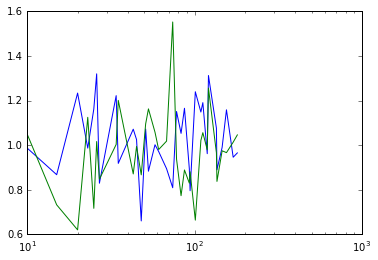

In [206]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.semilogx(all_time, g2)
plt.show()

In [207]:
for time in t:
    print (time)

[0]
[0, 10]
[0, 15, 25]
[0, 20, 35, 45]
[0, 23, 43, 58, 68]
[0, 25, 48, 68, 83, 93]
[0, 26, 51, 74, 94, 109, 119]
[0, 27, 53, 78, 101, 121, 136, 146]
[0, 34, 61, 87, 112, 135, 155, 170, 180]


In [63]:
ab = itertools.chain(t)
list(ab)

[[0],
 [0, 10],
 [0, 15, 25],
 [0, 20, 35, 45],
 [0, 23, 43, 58, 68],
 [0, 25, 48, 68, 83, 93],
 [0, 26, 51, 74, 94, 109, 119],
 [0, 27, 53, 78, 101, 121, 136, 146],
 [0, 34, 61, 87, 112, 135, 155, 170, 180]]

In [5]:
import skbeam.core.roi as roi
label_array = []
pixel_list = []

label_array, pixel_list = roi.extract_label_indices(rois)

In [6]:
for i in (np.unique(rois)[1:]):
    print (i)

3
5


In [7]:
label_array

array([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3])

In [8]:
pixel_list

array([   0,    1,    2,    3,    4,    5,    6,    7,   80,   81,   82,
         83,   84,   85,   86,   87,  160,  161,  162,  163,  164,  165,
        166,  167,  240,  241,  242,  243,  244,  245,  246,  247,  320,
        321,  322,  323,  324,  325,  326,  327,  400,  401,  402,  403,
        404,  405,  406,  407,  480,  481,  482,  483,  484,  485,  486,
        487,  560,  561,  562,  563,  564,  565,  566,  567,  648,  649,
        650,  651,  652,  653,  654,  655,  728,  729,  730,  731,  732,
        733,  734,  735,  808,  809,  810,  811,  812,  813,  814,  815,
        888,  889,  890,  891,  892,  893,  894,  895,  968,  969,  970,
        971,  972,  973,  974,  975, 1048, 1049, 1050, 1051, 1052, 1053,
       1054, 1055, 1128, 1129, 1130, 1131, 1132, 1133, 1134, 1135, 1208,
       1209, 1210, 1211, 1212, 1213, 1214, 1215])

In [9]:
inner_radius = 3
width = 1
spacing = 1
num_rings = 4
center = (13, 14)

edges = roi.ring_edges(inner_radius, width, spacing, num_rings)
rings = roi.rings(edges, center, (25, 25))

In [10]:
label, pixels = roi.extract_label_indices(rings)

In [11]:
label

array([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4,
       3, 3, 3, 3, 4, 4, 3, 3, 2, 2, 2, 2, 2, 2, 2, 3, 3, 4, 4, 3, 2, 2, 2,
       2, 3, 4, 4, 3, 2, 2, 1, 1, 1, 1, 1, 2, 2, 3, 4, 4, 3, 2, 1, 1, 2, 3,
       4, 4, 3, 2, 1, 1, 2, 3, 4, 4, 3, 2, 1, 1, 2, 3, 4, 4, 3, 2, 1, 1, 2,
       3, 4, 4, 3, 2, 1, 1, 2, 3, 4, 4, 3, 2, 2, 1, 1, 1, 1, 1, 2, 2, 3, 4,
       4, 3, 2, 2, 2, 2, 3, 4, 4, 3, 3, 2, 2, 2, 2, 2, 2, 2, 3, 3, 4, 4, 3,
       3, 3, 3, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4])

In [12]:
pixels

array([110, 111, 112, 113, 114, 115, 116, 117, 118, 134, 144, 157, 158,
       161, 162, 163, 164, 165, 166, 167, 170, 171, 182, 184, 185, 193,
       194, 196, 206, 208, 209, 211, 212, 213, 214, 215, 216, 217, 219,
       220, 222, 230, 233, 235, 236, 242, 243, 245, 248, 255, 257, 259,
       260, 262, 263, 264, 265, 266, 268, 269, 271, 273, 280, 282, 284,
       286, 292, 294, 296, 298, 305, 307, 309, 311, 317, 319, 321, 323,
       330, 332, 334, 336, 342, 344, 346, 348, 355, 357, 359, 361, 367,
       369, 371, 373, 380, 382, 384, 386, 392, 394, 396, 398, 405, 407,
       409, 410, 412, 413, 414, 415, 416, 418, 419, 421, 423, 430, 433,
       435, 436, 442, 443, 445, 448, 456, 458, 459, 461, 462, 463, 464,
       465, 466, 467, 469, 470, 472, 482, 484, 485, 493, 494, 496, 507,
       508, 511, 512, 513, 514, 515, 516, 517, 520, 521, 534, 544, 560,
       561, 562, 563, 564, 565, 566, 567, 568])

In [13]:
pixels[label==4]

array([110, 111, 112, 113, 114, 115, 116, 117, 118, 134, 144, 157, 158,
       170, 171, 182, 196, 206, 222, 230, 248, 255, 273, 280, 298, 305,
       323, 330, 348, 355, 373, 380, 398, 405, 423, 430, 448, 456, 472,
       482, 496, 507, 508, 520, 521, 534, 544, 560, 561, 562, 563, 564,
       565, 566, 567, 568])

In [14]:
label_mapping = {label: n+1
                     for n, label in enumerate(np.unique(label_array))}
# remap the label array to go from 1 -> max(_labels)
for label, n in label_mapping.items():
        label_array[label_array == label] = n

# number of ROI's
num_rois = len(label_mapping)

In [15]:
num_rois

2

In [16]:
label_array

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [17]:
pixel_list

array([   0,    1,    2,    3,    4,    5,    6,    7,   80,   81,   82,
         83,   84,   85,   86,   87,  160,  161,  162,  163,  164,  165,
        166,  167,  240,  241,  242,  243,  244,  245,  246,  247,  320,
        321,  322,  323,  324,  325,  326,  327,  400,  401,  402,  403,
        404,  405,  406,  407,  480,  481,  482,  483,  484,  485,  486,
        487,  560,  561,  562,  563,  564,  565,  566,  567,  648,  649,
        650,  651,  652,  653,  654,  655,  728,  729,  730,  731,  732,
        733,  734,  735,  808,  809,  810,  811,  812,  813,  814,  815,
        888,  889,  890,  891,  892,  893,  894,  895,  968,  969,  970,
        971,  972,  973,  974,  975, 1048, 1049, 1050, 1051, 1052, 1053,
       1054, 1055, 1128, 1129, 1130, 1131, 1132, 1133, 1134, 1135, 1208,
       1209, 1210, 1211, 1212, 1213, 1214, 1215])

In [18]:
pixel_list[label_array==2]

array([  0,   1,   2,   3,   4,   5,   6,   7,  80,  81,  82,  83,  84,
        85,  86,  87, 160, 161, 162, 163, 164, 165, 166, 167, 240, 241,
       242, 243, 244, 245, 246, 247, 320, 321, 322, 323, 324, 325, 326,
       327, 400, 401, 402, 403, 404, 405, 406, 407, 480, 481, 482, 483,
       484, 485, 486, 487, 560, 561, 562, 563, 564, 565, 566, 567])

In [19]:
num_rois

2

In [20]:
for i in range(num_rois):
    print (i+1)

1
2


In [21]:
(label_array, pixel_list, num_rois, num_pixels, lag_steps, buf, img_per_level, track_level, cur,
            norm, lev_len)= _validate_and_transform_inputs(num_bufs, num_levels, rois)

In [22]:
buf

{0: array([[[ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.]],
 
        [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.]],
 
        [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.]],
 
        [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.]],
 
        [[ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.,  0.,  0., ...,  0.,  0.,  0.]]]),
 1: array([[[ 0.,  0.,  0., ...,  0.,  0.,  0.],
         [ 0.

In [30]:
G = np.zeros((num_rois, (num_levels + 1) * num_bufs / 2),
                 dtype=np.float64)

/Users/sameera/mc/envs/py3k/lib/python3.4/site-packages/ipykernel/__main__.py:2: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  from ipykernel import kernelapp as app


In [31]:
G.shape

(2, 12)

In [32]:
G[0]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [34]:
num_pixels[0]

64

In [35]:
label_array

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])